<a href="https://colab.research.google.com/github/thesea58/transformer/blob/main/TF_hop_am_512_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Apr 17 13:00:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# cài dặt và import thư viện

In [2]:
import os
import math
import time
import json
import music21 as m21
import numpy as np
import pandas as pd
import glob
import pickle
from tqdm import tqdm
import tensorflow as tf
# from tensorflow.keras.utils import pad_sequences
from typing import Collection, List

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/AI nhac viet/code/
import convert 
import convert_goc
import vocab 
import numpy_encode 
import transformer_tf as transf_tf
import transformer
from  transformer import TransformerDecoder, TransformerMusicGenerator, MusicGenerator,ExportMusicGenerator
from  transformer import *
import tokenizer_dataset 
# import playmidi 

%cd ..

/content/drive/.shortcut-targets-by-id/1tM9cmHbycv0M-AtDYBu9bQ0sv5sb4e6W/AI nhac viet/code
/content/drive/.shortcut-targets-by-id/1tM9cmHbycv0M-AtDYBu9bQ0sv5sb4e6W/AI nhac viet


# dataset

In [5]:
max_len = 512
transpose = 6
batch_size = 40
created_vocab = convert_goc.MusicVocab.create()
print(f'vocabulary size: {len(created_vocab)}')
fp = './ai-music/midi_songs'

train_ds = convert_goc.create_dataset(fp, created_vocab, max_len, batch_size, transpose)
val_ds = convert_goc.create_dataset('./ai-music/midi_songs_val/', created_vocab, max_len, batch_size, transpose, shuffle=False)

# # Load the dataset from the file
# train_ds = tf.data.Dataset.load(f"./ai-music/dataset_MEGA_512_{batch_size}")

# # Prefetch the data to optimize performance
# train_ds = train_ds.prefetch(batch_size)
# print(f"có {len(train_ds)} batch")

vocabulary size: 298
tìm thấy 73 file 
0đã load lại: /content/drive/.shortcut-targets-by-id/1tM9cmHbycv0M-AtDYBu9bQ0sv5sb4e6W/AI nhac viet/ai-music/midi_songs/Cids.mid.txt
1đã load lại: /content/drive/.shortcut-targets-by-id/1tM9cmHbycv0M-AtDYBu9bQ0sv5sb4e6W/AI nhac viet/ai-music/midi_songs/DOS.mid.txt
2đã load lại: /content/drive/.shortcut-targets-by-id/1tM9cmHbycv0M-AtDYBu9bQ0sv5sb4e6W/AI nhac viet/ai-music/midi_songs/FF4.mid.txt
3đã load lại: /content/drive/.shortcut-targets-by-id/1tM9cmHbycv0M-AtDYBu9bQ0sv5sb4e6W/AI nhac viet/ai-music/midi_songs/FFIII_Edgar_And_Sabin_Piano.mid.txt
4đã load lại: /content/drive/.shortcut-targets-by-id/1tM9cmHbycv0M-AtDYBu9bQ0sv5sb4e6W/AI nhac viet/ai-music/midi_songs/FFIXQuMarshP.mid.txt
5đã load lại: /content/drive/.shortcut-targets-by-id/1tM9cmHbycv0M-AtDYBu9bQ0sv5sb4e6W/AI nhac viet/ai-music/midi_songs/FFIX_Piano.mid.txt
6đã load lại: /content/drive/.shortcut-targets-by-id/1tM9cmHbycv0M-AtDYBu9bQ0sv5sb4e6W/AI nhac viet/ai-music/midi_songs/FFX_-_En

In [ ]:
# q =2
# for i,o in train_ds.take(3):
#   pass
# print(i) 
# print(o) 

In [ ]:
# generated1 = convert_goc.idxenc2stream(i[2].numpy(), vocab=created_vocab)
# generated1.show('midi')
# generated2 = convert_goc.idxenc2stream(o[2].numpy(), vocab=created_vocab)
# generated2.show('midi')

In [ ]:
# tf.data.Dataset.save(train_ds, f"./dataset_MEGA_512_{batch_size}")

# build model và load checkpoint

In [6]:

num_layers = 6
d_model =   256
dff = 512
num_heads = 8
dropout_rate = 0.3
transformer_model = TransformerDecoder(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=len(created_vocab),
        pe_target=max_len,
        rate=dropout_rate)

# transformer_model = tf.saved_model.load('./code/save_model/decoder_only_smaller_1024_mega_ds_gh')

learning_rate = transformer.CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='validation_loss')
val_accuracy = tf.keras.metrics.Mean(name='validation_accuracy')

checkpoint_path = "./ai-music/ckpt/"

ckpt = tf.train.Checkpoint(transformer=transformer_model,
                            optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

gen_tokens = convert_goc.midi2idxenc('./data_midi_hopam/midi_songs/MEGA/Melody Of The Night 21.mid', created_vocab, add_bos=True, add_eos=True)[:128]
prev_train_loss = math.inf
prev_val_loss = math.inf
tf_generator = transformer.TransformerMusicGenerator(transformer_model, max_len)
exporter = transformer.ExportMusicGenerator(tf_generator)


train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    with tf.GradientTape() as tape:
        predictions, _ = transformer_model(inp, training=True)
        loss = transformer.loss_function(tar, predictions)

    gradients = tape.gradient(loss, transformer_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer_model.trainable_variables))

    train_loss(loss)
    train_accuracy(transformer.accuracy_function(tar, predictions))

None: converted ./data_midi_hopam/midi_songs/MEGA/Melody Of The Night 21.mid to index encoding (1517 tokens)


/content/drive/.shortcut-targets-by-id/1tM9cmHbycv0M-AtDYBu9bQ0sv5sb4e6W/AI nhac viet/code/numpy_encode.py:103: StreamIteratorInefficientWarning: highestTime is not defined on StreamIterators. Call .stream() first for efficiency
  highest_time = max(s.flat.getElementsByClass('Note').highestTime, s.flat.getElementsByClass('Chord').highestTime)


In [7]:
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')
    # tf_gen = TransformerMusicGenerator(transformer_model, max_len)
    # exporter = ExportMusicGenerator(tf_gen)
    # tokens_original = convert_goc.midi2idxenc('./data_midi_hopam/midi_songs/FF4.mid', created_vocab, add_bos=False, add_eos=False)[:256]
    # generator = MusicGenerator(exporter)
    # generator.save(fp='./code/save_model/decoder_only_smaller_1024_mega_ds')

    # gen_len = 128
    # generated = generator.extend_sequence(input_sequence=tokens_original, max_generate_len=gen_len)
    # print(generated[-(gen_len + 2):])
    # generated1 = convert_goc.idxenc2stream(tokens_original, vocab=created_vocab)
    # generated1.show('midi')
    # generated2 = convert_goc.idxenc2stream(generated.numpy(), vocab=created_vocab)
    # generated2.show('midi')
    # generated.write('midi', fp='../generated/generated_greed.mid')


Latest checkpoint restored!!


In [8]:
p = 5
for (batch, (val_inp, val_tar)) in enumerate(train_ds.take(90)):    
    pass
val_logits, _ = transformer_model(val_inp[:256], training=False)
print(val_accuracy(transformer.accuracy_function(val_tar, val_logits)))

next_token = tf.argmax(val_logits, axis=-1).numpy()
# target = np.concatenate((val_inp.numpy()[p],val_inp[:120].numpy()[p]))
predic = np.concatenate((val_inp.numpy()[p],next_token[p]))

input_stream = convert_goc.idxenc2stream(val_inp.numpy()[p], vocab=created_vocab)
input_stream.show('midi')
target_stream = convert_goc.idxenc2stream(val_inp.numpy()[p][120:], vocab=created_vocab)
target_stream.show('midi')
input_stream = convert_goc.idxenc2stream(predic, vocab=created_vocab)
input_stream.show('midi')

tf.Tensor(0.98445183, shape=(), dtype=float32)


## Train

In [9]:
#@title plot loss acc
import matplotlib.pyplot as plt
def plot_loss_acc(df):
    # Vẽ b  iểu đồ epoch vs. loss
    plt.plot(df['Epoch'], df['Loss'], label='Training Loss')
    plt.plot(df['Epoch'], df['Loss val'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Vẽ biểu đồ epoch vs. accuracy
    plt.plot(df['Epoch'], df['Accuracy'], label='Training Accuracy')
    plt.plot(df['Epoch'], df['Accuracy val'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Vẽ biểu đồ loss vs. accuracy
    plt.plot(df['Loss'], df['Accuracy'], label='Training')
    plt.plot(df['Loss val'], df['Accuracy val'], label='Validation')
    plt.xlabel('Loss')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Vẽ biểu đồ epoch vs. loss và accuracy
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(df['Epoch'], df['Loss'], color=color, label='Training Loss')
    ax1.plot(df['Epoch'], df['Loss val'], color=color, linestyle='dashed', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()  # Tạo trục thứ hai
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy')
    ax2.plot(df['Epoch'], df['Accuracy'], color=color, label='Training Accuracy')
    ax2.plot(df['Epoch'], df['Accuracy val'], color=color, linestyle='dashed', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.show()

load history!
     Epoch  Loss val  Accuracy val      Loss  Accuracy
0      1.0  3.563023      0.303163  4.789773  0.173388
1      2.0  3.246876      0.347241  3.520590  0.295426
2      3.0  2.952721      0.401571  2.944909  0.423248
3      4.0  2.780214      0.425357  2.502471  0.479996
4      5.0  2.672300      0.439460  2.378871  0.484096
..     ...       ...           ...       ...       ...
268  269.0  6.648611      0.282396  0.212895  0.930209
269  270.0  6.655656      0.282422  0.215392  0.929782
270  271.0  6.662836      0.282475  0.211069  0.930980
271  272.0  6.669478      0.282572  0.208832  0.931884
272  273.0  6.676002      0.282579  0.210975  0.931000

[273 rows x 5 columns]


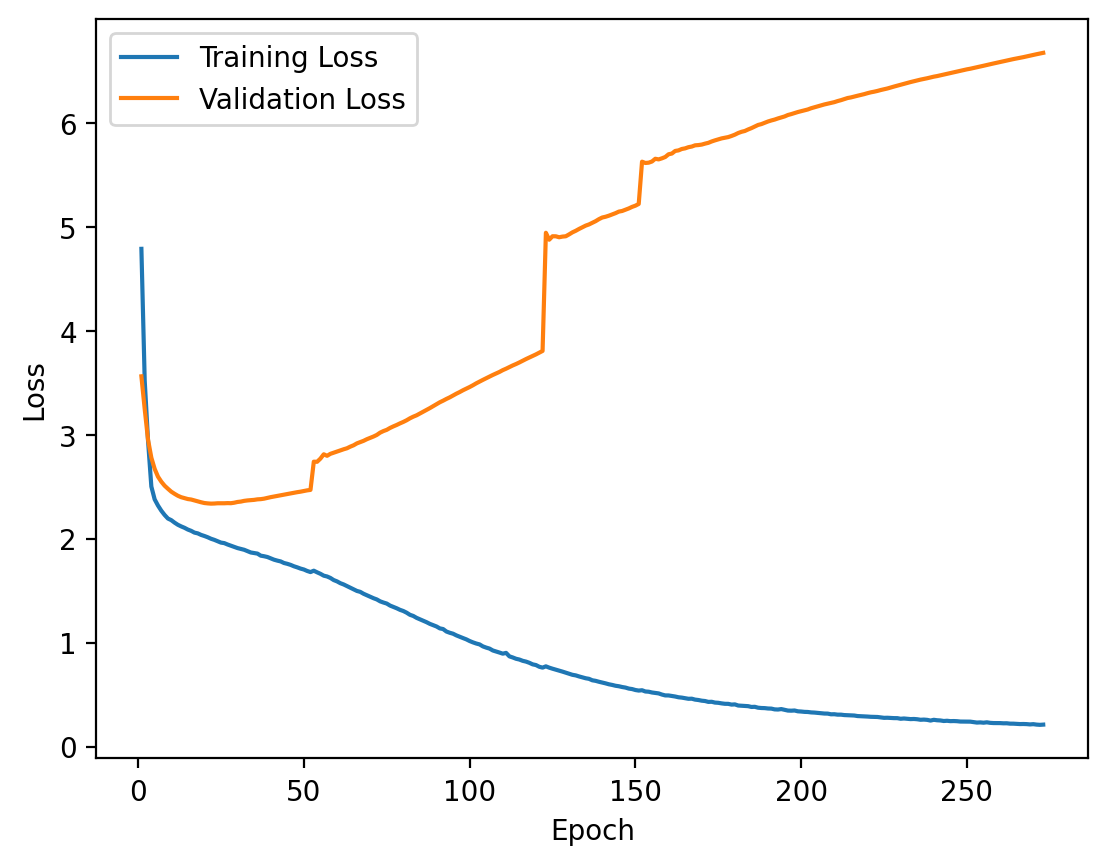

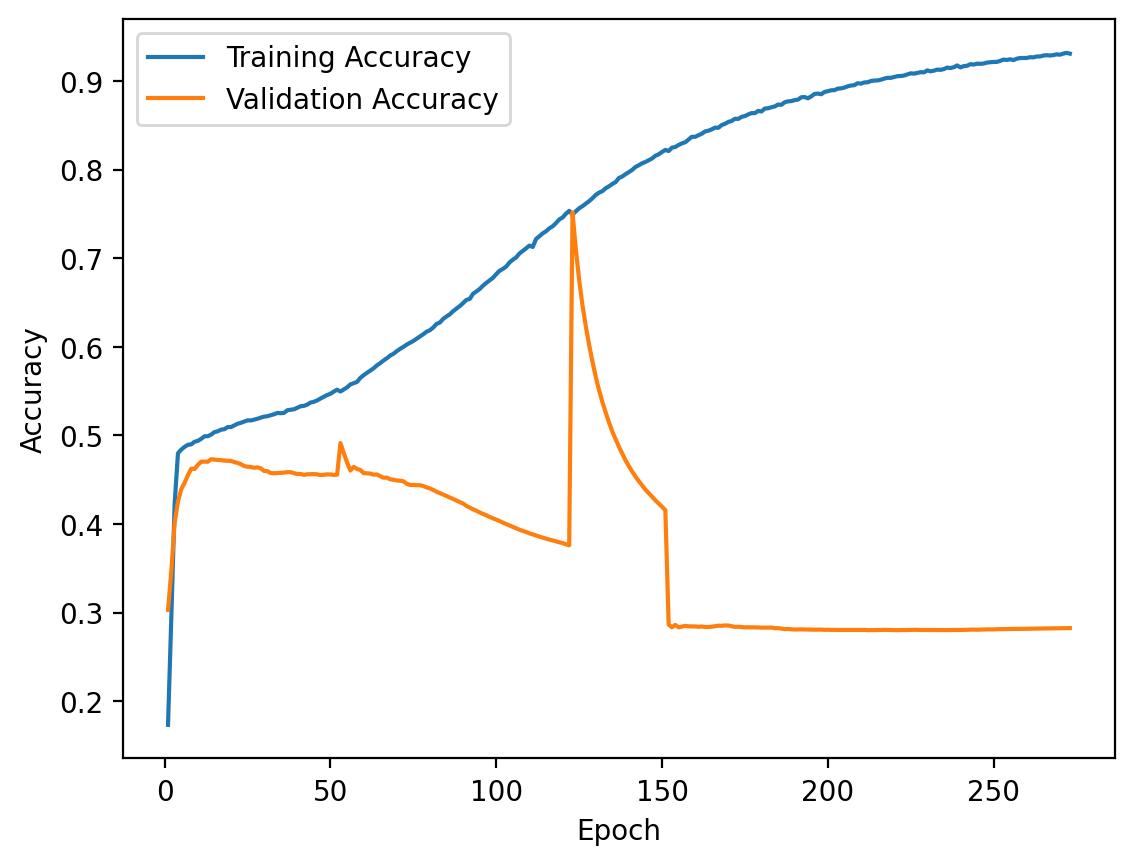

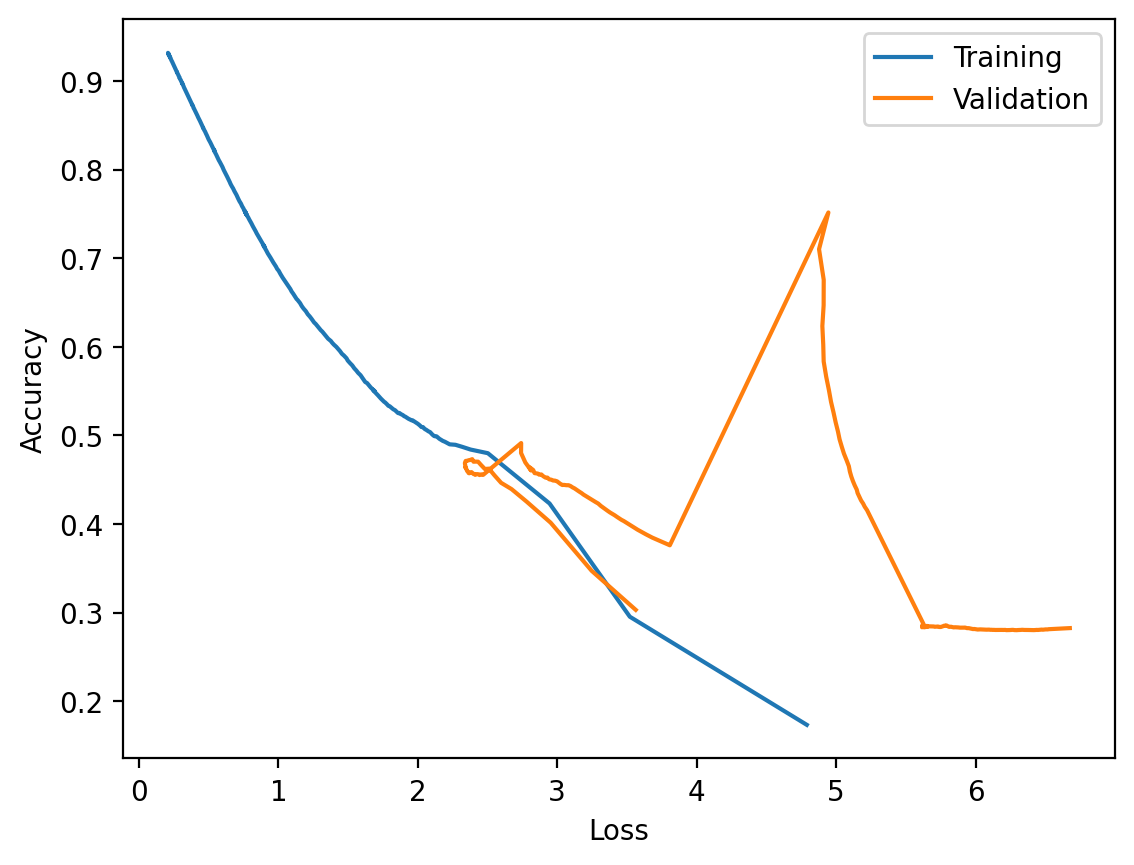

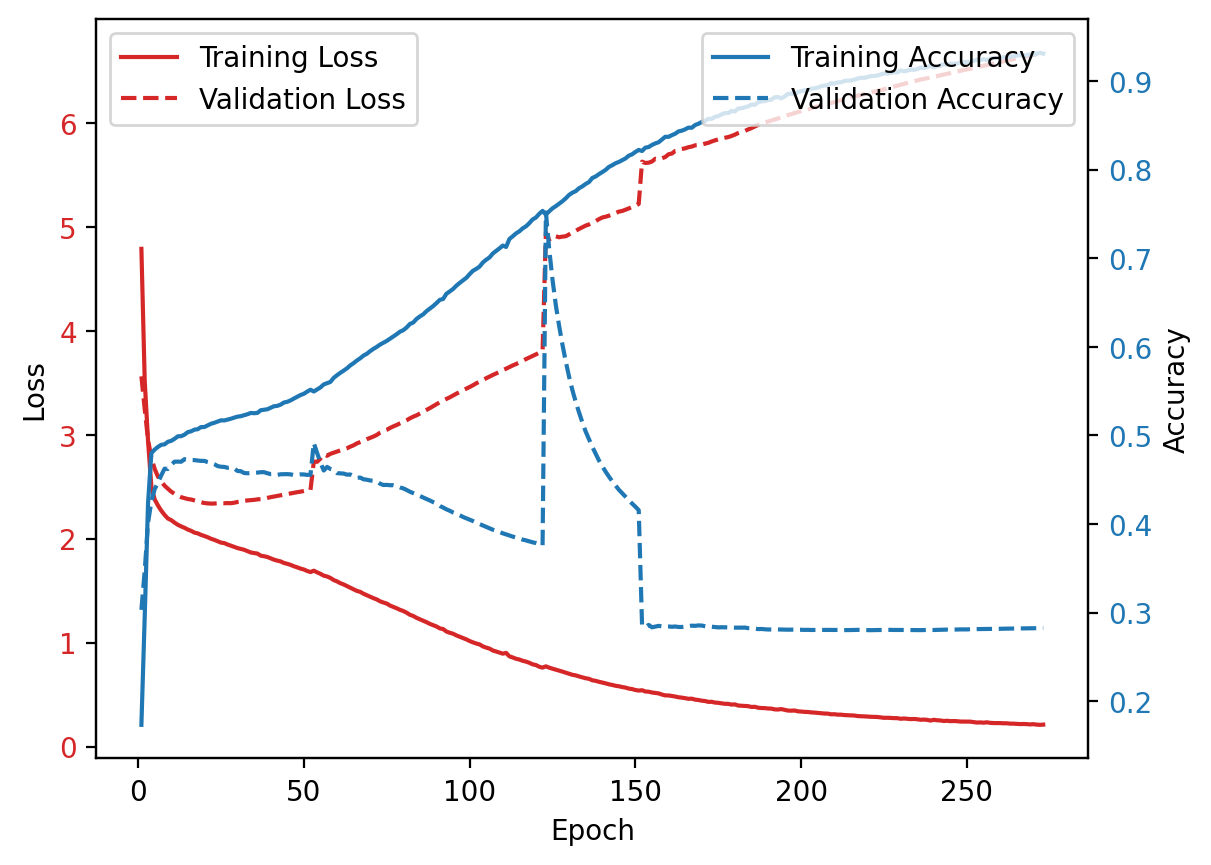

In [10]:
import re
history_path = './ai-music/history_512_df.csv'
print('load history!')
history = pd.read_csv(history_path, index_col=False)
# plot_loss_acc(history)
def chuyen_history_loi(df):
    # Kiểm tra kết quả
    df = history

    # Trích xuất giá trị số từ cột Epoch
    df['Epoch'] = df['Epoch'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

    # Trích xuất giá trị số từ các cột còn lại
    regex = r'(\d+(\.\d+)?)'
    for col in df.columns[1:]:
        df[col] = df[col].apply(lambda x: float(re.findall(regex, x)[0][0]))
    return df

# Kiểm tra kết quả
# history = chuyen_history_loi(history)
print(history)
plot_loss_acc(history)
# history.to_csv(history_path, index=False)


In [ ]:

# làm rỗng history
# col = {'Epoch': [],
#         'Loss val': [],
#         'Accuracy val': [],
#         'Loss': [],
#         'Accuracy': []}
# history_path = './history_MEGA_512_df.csv'
# history = pd.DataFrame(col)
# history.to_csv(history_path, index=False)

In [ ]:

import warnings
warnings.filterwarnings('ignore', message='The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.')


col = {'Epoch': [],
        'Loss val': [],
        'Accuracy val': [],
        'Loss': [],
        'Accuracy': []}
# history_path = './history_MEGA_512_df.csv'


if os.path.isfile(history_path):
    print('load history!')
    history = pd.read_csv(history_path, index_col=False)
else:
    print('tạo df history!')
    history = pd.DataFrame(col)


EPOCHS = 150
if len(history['Epoch'])>0:
  max_epoch = history['Epoch'].max()
else:
  max_epoch = 0
print(f"băt đầu lại từ epoch{max_epoch+1}")
for epoch in range((int(max_epoch)),int(max_epoch+EPOCHS),1):
        start = time.time()
        train_loss.reset_states()
        train_accuracy.reset_states()

        # inp -> seq, tar -> seq(shifted +1)
        for (batch, (train_inp, train_tar)) in tqdm(enumerate(train_ds), total = len(train_ds)):
            
            train_start = time.time()
            train_step(train_inp, train_tar)
            train_time = time.time() - train_start
            # if batch % 5 == 0:
            train_loss_batch = train_loss.result()
            train_accuracy_batch = train_accuracy.result()
            if batch %30 ==0 :
                print(
                    f'Epoch {epoch + 1} Batch {batch} Loss {train_loss_batch:.4f} Accuracy {train_accuracy_batch:.4f}')
            # description = f"Epoch {epoch + 1} | Loss: {train_loss_batch:.4f} | Acc: {train_accuracy_batch:.4f}"
            # tqdm.write(description)

            # tqdm.set_description(description, refresh=True)

        # Run a validation loop at the end of each epoch.
        for (batch, (val_inp, val_tar)) in enumerate(val_ds):
            val_logits, _ = transformer_model(val_inp, training=False)
            # Update val metrics
            val_loss_calc = transformer.loss_function(val_tar, val_logits)
            val_loss(val_loss_calc)
            val_accuracy(transformer.accuracy_function(val_tar, val_logits))
        val_acc_res = val_accuracy.result()
        val_loss_res = val_loss.result()

        train_loss_epoch = train_loss.result()
        train_accuracy_epoch = train_accuracy.result()
        print(f'Epoch {epoch + 1}: Loss {train_loss_epoch:.4f}, Valiation loss {val_loss_res:.4f}, Accuracy {train_accuracy_epoch:.4f}, Valiation accuracy {val_acc_res:.4f}')
        step = {'Epoch': int(epoch) + 1,
                'Loss val': val_loss_res.numpy(),
                'Accuracy val': val_acc_res.numpy(),
                'Loss': train_loss_epoch.numpy(),
                'Accuracy': train_accuracy_epoch.numpy()}

        history = history.append(step, ignore_index=True)
        history.to_csv(history_path, index=False)
        print("đã lưu lại history !")

        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs')
        if (epoch + 1) % 5 == 0:
            if train_loss_epoch < prev_train_loss or val_loss_res < prev_val_loss:
                print(f'#####################{prev_train_loss:.4f} -> {train_loss_epoch:.4f}')
                prev_train_loss = train_loss_epoch
                prev_val_loss = val_loss_res
                gen_time_start = time.time()
                gen = tf_generator.iterative_search(tf.convert_to_tensor(gen_tokens), 32, True, 0, 0, 0, 1.0)[0]
                gen_time = time.time() - gen_time_start
                # Print the 4 last tokens in the generation input as well to check if the output makes sense
                print(f'generated({gen_time:.4f}):\n{gen[-36:]}\n')
                stream = convert_goc.idxenc2stream(gen.numpy(), created_vocab)
                stream.show('midi')
                stream.write('midi', fp='./generated_greed.mid')
                ckpt_save_path = ckpt_manager.save()
                print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')
        if train_accuracy_epoch > 0.95:
            ckpt_save_path = ckpt_manager.save()
            print(f'break and Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')
            break;

load history!
băt đầu lại từ epoch152.0


  1%|▏         | 1/78 [00:26<34:15, 26.70s/it]

Epoch 152 Batch 0 Loss 0.5989 Accuracy 0.8046


 40%|███▉      | 31/78 [00:40<00:23,  1.98it/s]

Epoch 152 Batch 30 Loss 0.6146 Accuracy 0.7972


 79%|███████▉  | 62/78 [00:53<00:06,  2.44it/s]

Epoch 152 Batch 60 Loss 0.5621 Accuracy 0.8143


100%|██████████| 78/78 [01:01<00:00,  1.28it/s]


Epoch 152: Loss 0.5419, Valiation loss 5.6287, Accuracy 0.8211, Valiation accuracy 0.2865
đã lưu lại history !
Time taken for 1 epoch: 61.80 secs


  1%|▏         | 1/78 [00:00<00:34,  2.23it/s]

Epoch 153 Batch 0 Loss 0.5870 Accuracy 0.8062


 40%|███▉      | 31/78 [00:13<00:24,  1.92it/s]

Epoch 153 Batch 30 Loss 0.5966 Accuracy 0.8035


 78%|███████▊  | 61/78 [00:27<00:08,  1.90it/s]

Epoch 153 Batch 60 Loss 0.5480 Accuracy 0.8190


100%|██████████| 78/78 [00:35<00:00,  2.23it/s]


Epoch 153: Loss 0.5299, Valiation loss 5.6162, Accuracy 0.8249, Valiation accuracy 0.2835
đã lưu lại history !
Time taken for 1 epoch: 36.61 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 154 Batch 0 Loss 0.5749 Accuracy 0.8137


 40%|███▉      | 31/78 [00:14<00:25,  1.87it/s]

Epoch 154 Batch 30 Loss 0.5925 Accuracy 0.8039


 78%|███████▊  | 61/78 [00:27<00:09,  1.88it/s]

Epoch 154 Batch 60 Loss 0.5478 Accuracy 0.8189


100%|██████████| 78/78 [00:35<00:00,  2.21it/s]


Epoch 154: Loss 0.5277, Valiation loss 5.6191, Accuracy 0.8256, Valiation accuracy 0.2862
đã lưu lại history !
Time taken for 1 epoch: 41.38 secs


  1%|▏         | 1/78 [00:00<00:35,  2.20it/s]

Epoch 155 Batch 0 Loss 0.5304 Accuracy 0.8219


 40%|███▉      | 31/78 [00:14<00:25,  1.87it/s]

Epoch 155 Batch 30 Loss 0.5913 Accuracy 0.8043


 78%|███████▊  | 61/78 [00:27<00:09,  1.87it/s]

Epoch 155 Batch 60 Loss 0.5386 Accuracy 0.8218


100%|██████████| 78/78 [00:35<00:00,  2.20it/s]


Epoch 155: Loss 0.5201, Valiation loss 5.6303, Accuracy 0.8279, Valiation accuracy 0.2835
đã lưu lại history !
Time taken for 1 epoch: 36.20 secs
#####################inf -> 0.5201
generated(4.0377):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 136 136 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 155 at ./ai-music/ckpt/ckpt-33


  1%|▏         | 1/78 [00:00<00:39,  1.94it/s]

Epoch 156 Batch 0 Loss 0.5781 Accuracy 0.8103


 40%|███▉      | 31/78 [00:14<00:25,  1.86it/s]

Epoch 156 Batch 30 Loss 0.5836 Accuracy 0.8074


 78%|███████▊  | 61/78 [00:28<00:09,  1.86it/s]

Epoch 156 Batch 60 Loss 0.5349 Accuracy 0.8234


100%|██████████| 78/78 [00:35<00:00,  2.18it/s]


Epoch 156: Loss 0.5154, Valiation loss 5.6566, Accuracy 0.8297, Valiation accuracy 0.2842
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:35,  2.18it/s]

Epoch 157 Batch 0 Loss 0.5823 Accuracy 0.8086


 40%|███▉      | 31/78 [00:14<00:25,  1.86it/s]

Epoch 157 Batch 30 Loss 0.5845 Accuracy 0.8077


 78%|███████▊  | 61/78 [00:28<00:09,  1.85it/s]

Epoch 157 Batch 60 Loss 0.5286 Accuracy 0.8255


100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


Epoch 157: Loss 0.5115, Valiation loss 5.6506, Accuracy 0.8310, Valiation accuracy 0.2851
đã lưu lại history !
Time taken for 1 epoch: 36.42 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 158 Batch 0 Loss 0.5777 Accuracy 0.8092


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 158 Batch 30 Loss 0.5649 Accuracy 0.8124


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 158 Batch 60 Loss 0.5183 Accuracy 0.8281


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


Epoch 158: Loss 0.5003, Valiation loss 5.6609, Accuracy 0.8341, Valiation accuracy 0.2846
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs


  1%|▏         | 1/78 [00:00<00:35,  2.17it/s]

Epoch 159 Batch 0 Loss 0.5261 Accuracy 0.8276


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 159 Batch 30 Loss 0.5551 Accuracy 0.8159


 78%|███████▊  | 61/78 [00:28<00:09,  1.85it/s]

Epoch 159 Batch 60 Loss 0.5092 Accuracy 0.8315


100%|██████████| 78/78 [00:36<00:00,  2.16it/s]


Epoch 159: Loss 0.4921, Valiation loss 5.6737, Accuracy 0.8371, Valiation accuracy 0.2845
đã lưu lại history !
Time taken for 1 epoch: 36.74 secs


  1%|▏         | 1/78 [00:00<00:36,  2.10it/s]

Epoch 160 Batch 0 Loss 0.5624 Accuracy 0.8149


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 160 Batch 30 Loss 0.5587 Accuracy 0.8150


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 160 Batch 60 Loss 0.5097 Accuracy 0.8310


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 160: Loss 0.4918, Valiation loss 5.6999, Accuracy 0.8371, Valiation accuracy 0.2844
đã lưu lại history !
Time taken for 1 epoch: 36.86 secs
#####################0.5201 -> 0.4918
generated(4.2854):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 160 at ./ai-music/ckpt/ckpt-34


  1%|▏         | 1/78 [00:00<00:38,  1.98it/s]

Epoch 161 Batch 0 Loss 0.5438 Accuracy 0.8224


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 161 Batch 30 Loss 0.5539 Accuracy 0.8167


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 161 Batch 60 Loss 0.5043 Accuracy 0.8333


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 161: Loss 0.4867, Valiation loss 5.7069, Accuracy 0.8390, Valiation accuracy 0.2841
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 162 Batch 0 Loss 0.5624 Accuracy 0.8178


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 162 Batch 30 Loss 0.5545 Accuracy 0.8165


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 162 Batch 60 Loss 0.5006 Accuracy 0.8343


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 162: Loss 0.4814, Valiation loss 5.7319, Accuracy 0.8406, Valiation accuracy 0.2844
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 163 Batch 0 Loss 0.5291 Accuracy 0.8227


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 163 Batch 30 Loss 0.5289 Accuracy 0.8246


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 163 Batch 60 Loss 0.4898 Accuracy 0.8379


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 163: Loss 0.4741, Valiation loss 5.7373, Accuracy 0.8432, Valiation accuracy 0.2838
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:35,  2.14it/s]

Epoch 164 Batch 0 Loss 0.5050 Accuracy 0.8342


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 164 Batch 30 Loss 0.5372 Accuracy 0.8219


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 164 Batch 60 Loss 0.4894 Accuracy 0.8378


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 164: Loss 0.4708, Valiation loss 5.7508, Accuracy 0.8440, Valiation accuracy 0.2838
đã lưu lại history !
Time taken for 1 epoch: 37.00 secs


  1%|▏         | 1/78 [00:00<00:36,  2.14it/s]

Epoch 165 Batch 0 Loss 0.5315 Accuracy 0.8229


 40%|███▉      | 31/78 [00:14<00:25,  1.85it/s]

Epoch 165 Batch 30 Loss 0.5249 Accuracy 0.8251


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 165 Batch 60 Loss 0.4844 Accuracy 0.8392


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 165: Loss 0.4657, Valiation loss 5.7568, Accuracy 0.8455, Valiation accuracy 0.2842
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs
#####################0.4918 -> 0.4657
generated(3.3155):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 165 at ./ai-music/ckpt/ckpt-35


  1%|▏         | 1/78 [00:00<00:39,  1.94it/s]

Epoch 166 Batch 0 Loss 0.4824 Accuracy 0.8372


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 166 Batch 30 Loss 0.5201 Accuracy 0.8273


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 166 Batch 60 Loss 0.4747 Accuracy 0.8425


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 166: Loss 0.4596, Valiation loss 5.7680, Accuracy 0.8475, Valiation accuracy 0.2848
đã lưu lại history !
Time taken for 1 epoch: 41.38 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 167 Batch 0 Loss 0.5286 Accuracy 0.8277


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 167 Batch 30 Loss 0.5295 Accuracy 0.8243


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 167 Batch 60 Loss 0.4789 Accuracy 0.8411


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 167: Loss 0.4604, Valiation loss 5.7742, Accuracy 0.8473, Valiation accuracy 0.2853
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:36,  2.11it/s]

Epoch 168 Batch 0 Loss 0.4870 Accuracy 0.8392


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 168 Batch 30 Loss 0.5069 Accuracy 0.8315


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 168 Batch 60 Loss 0.4685 Accuracy 0.8446


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 168: Loss 0.4516, Valiation loss 5.7860, Accuracy 0.8504, Valiation accuracy 0.2851
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 169 Batch 0 Loss 0.5059 Accuracy 0.8320


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 169 Batch 30 Loss 0.5102 Accuracy 0.8310


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 169 Batch 60 Loss 0.4646 Accuracy 0.8461


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 169: Loss 0.4478, Valiation loss 5.7885, Accuracy 0.8518, Valiation accuracy 0.2856
đã lưu lại history !
Time taken for 1 epoch: 36.80 secs


  1%|▏         | 1/78 [00:00<00:37,  2.06it/s]

Epoch 170 Batch 0 Loss 0.5084 Accuracy 0.8329


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 170 Batch 30 Loss 0.5011 Accuracy 0.8340


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 170 Batch 60 Loss 0.4540 Accuracy 0.8496


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 170: Loss 0.4413, Valiation loss 5.7931, Accuracy 0.8539, Valiation accuracy 0.2855
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs
#####################0.4657 -> 0.4413
generated(3.4638):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 170 at ./ai-music/ckpt/ckpt-36


  1%|▏         | 1/78 [00:00<00:39,  1.96it/s]

Epoch 171 Batch 0 Loss 0.4664 Accuracy 0.8478


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 171 Batch 30 Loss 0.4929 Accuracy 0.8366


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 171 Batch 60 Loss 0.4546 Accuracy 0.8493


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 171: Loss 0.4381, Valiation loss 5.8022, Accuracy 0.8550, Valiation accuracy 0.2847
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:36,  2.14it/s]

Epoch 172 Batch 0 Loss 0.4950 Accuracy 0.8339


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 172 Batch 30 Loss 0.4876 Accuracy 0.8384


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 172 Batch 60 Loss 0.4462 Accuracy 0.8522


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 172: Loss 0.4297, Valiation loss 5.8100, Accuracy 0.8575, Valiation accuracy 0.2839
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 173 Batch 0 Loss 0.4902 Accuracy 0.8385


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 173 Batch 30 Loss 0.4814 Accuracy 0.8398


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 173 Batch 60 Loss 0.4460 Accuracy 0.8521


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 173: Loss 0.4307, Valiation loss 5.8231, Accuracy 0.8573, Valiation accuracy 0.2841
đã lưu lại history !
Time taken for 1 epoch: 36.91 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 174 Batch 0 Loss 0.4926 Accuracy 0.8369


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 174 Batch 30 Loss 0.4752 Accuracy 0.8419


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 174 Batch 60 Loss 0.4362 Accuracy 0.8552


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 174: Loss 0.4230, Valiation loss 5.8338, Accuracy 0.8597, Valiation accuracy 0.2837
đã lưu lại history !
Time taken for 1 epoch: 37.06 secs


  1%|▏         | 1/78 [00:00<00:35,  2.14it/s]

Epoch 175 Batch 0 Loss 0.4638 Accuracy 0.8489


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 175 Batch 30 Loss 0.4712 Accuracy 0.8435


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 175 Batch 60 Loss 0.4340 Accuracy 0.8562


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 175: Loss 0.4209, Valiation loss 5.8428, Accuracy 0.8606, Valiation accuracy 0.2834
đã lưu lại history !
Time taken for 1 epoch: 37.01 secs
#####################0.4413 -> 0.4209
generated(4.1163):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 138 138 138 138 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 175 at ./ai-music/ckpt/ckpt-37


  1%|▏         | 1/78 [00:00<00:40,  1.91it/s]

Epoch 176 Batch 0 Loss 0.4656 Accuracy 0.8490


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 176 Batch 30 Loss 0.4704 Accuracy 0.8440


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 176 Batch 60 Loss 0.4319 Accuracy 0.8568


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 176: Loss 0.4154, Valiation loss 5.8527, Accuracy 0.8624, Valiation accuracy 0.2835
đã lưu lại history !
Time taken for 1 epoch: 41.36 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 177 Batch 0 Loss 0.4573 Accuracy 0.8512


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 177 Batch 30 Loss 0.4579 Accuracy 0.8480


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 177 Batch 60 Loss 0.4251 Accuracy 0.8592


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 177: Loss 0.4114, Valiation loss 5.8589, Accuracy 0.8639, Valiation accuracy 0.2835
đã lưu lại history !
Time taken for 1 epoch: 41.38 secs


  1%|▏         | 1/78 [00:00<00:35,  2.16it/s]

Epoch 178 Batch 0 Loss 0.4688 Accuracy 0.8441


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 178 Batch 30 Loss 0.4660 Accuracy 0.8452


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 178 Batch 60 Loss 0.4255 Accuracy 0.8589


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 178: Loss 0.4108, Valiation loss 5.8654, Accuracy 0.8638, Valiation accuracy 0.2835
đã lưu lại history !
Time taken for 1 epoch: 36.88 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 179 Batch 0 Loss 0.4372 Accuracy 0.8582


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 179 Batch 30 Loss 0.4519 Accuracy 0.8505


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 179 Batch 60 Loss 0.4159 Accuracy 0.8621


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 179: Loss 0.4037, Valiation loss 5.8762, Accuracy 0.8664, Valiation accuracy 0.2833
đã lưu lại history !
Time taken for 1 epoch: 37.04 secs


  1%|▏         | 1/78 [00:00<00:36,  2.09it/s]

Epoch 180 Batch 0 Loss 0.4662 Accuracy 0.8469


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 180 Batch 30 Loss 0.4585 Accuracy 0.8482


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 180 Batch 60 Loss 0.4217 Accuracy 0.8604


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 180: Loss 0.4057, Valiation loss 5.8887, Accuracy 0.8657, Valiation accuracy 0.2831
đã lưu lại history !
Time taken for 1 epoch: 41.38 secs
#####################0.4209 -> 0.4057
generated(3.3756):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 180 at ./ai-music/ckpt/ckpt-38


  1%|▏         | 1/78 [00:00<00:39,  1.95it/s]

Epoch 181 Batch 0 Loss 0.4502 Accuracy 0.8530


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 181 Batch 30 Loss 0.4450 Accuracy 0.8519


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 181 Batch 60 Loss 0.4105 Accuracy 0.8637


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 181: Loss 0.3948, Valiation loss 5.9044, Accuracy 0.8691, Valiation accuracy 0.2831
đã lưu lại history !
Time taken for 1 epoch: 36.92 secs


  1%|▏         | 1/78 [00:00<00:36,  2.14it/s]

Epoch 182 Batch 0 Loss 0.4400 Accuracy 0.8568


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 182 Batch 30 Loss 0.4435 Accuracy 0.8523


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 182 Batch 60 Loss 0.4085 Accuracy 0.8642


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 182: Loss 0.3928, Valiation loss 5.9160, Accuracy 0.8693, Valiation accuracy 0.2831
đã lưu lại history !
Time taken for 1 epoch: 37.04 secs


  1%|▏         | 1/78 [00:00<00:36,  2.10it/s]

Epoch 183 Batch 0 Loss 0.4388 Accuracy 0.8545


 40%|███▉      | 31/78 [00:14<00:25,  1.81it/s]

Epoch 183 Batch 30 Loss 0.4442 Accuracy 0.8520


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 183 Batch 60 Loss 0.4043 Accuracy 0.8656


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 183: Loss 0.3900, Valiation loss 5.9240, Accuracy 0.8705, Valiation accuracy 0.2832
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:35,  2.14it/s]

Epoch 184 Batch 0 Loss 0.4725 Accuracy 0.8447


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 184 Batch 30 Loss 0.4428 Accuracy 0.8531


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 184 Batch 60 Loss 0.4042 Accuracy 0.8662


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 184: Loss 0.3886, Valiation loss 5.9386, Accuracy 0.8714, Valiation accuracy 0.2825
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 185 Batch 0 Loss 0.4527 Accuracy 0.8476


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 185 Batch 30 Loss 0.4214 Accuracy 0.8597


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 185 Batch 60 Loss 0.3948 Accuracy 0.8690


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 185: Loss 0.3811, Valiation loss 5.9516, Accuracy 0.8735, Valiation accuracy 0.2825
đã lưu lại history !
Time taken for 1 epoch: 37.01 secs
#####################0.4057 -> 0.3811
generated(3.3308):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 185 at ./ai-music/ckpt/ckpt-39


  1%|▏         | 1/78 [00:00<00:41,  1.87it/s]

Epoch 186 Batch 0 Loss 0.4043 Accuracy 0.8695


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 186 Batch 30 Loss 0.4303 Accuracy 0.8569


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 186 Batch 60 Loss 0.3979 Accuracy 0.8679


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 186: Loss 0.3824, Valiation loss 5.9664, Accuracy 0.8732, Valiation accuracy 0.2821
đã lưu lại history !
Time taken for 1 epoch: 41.38 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 187 Batch 0 Loss 0.4086 Accuracy 0.8645


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 187 Batch 30 Loss 0.4160 Accuracy 0.8618


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 187 Batch 60 Loss 0.3880 Accuracy 0.8713


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 187: Loss 0.3738, Valiation loss 5.9820, Accuracy 0.8761, Valiation accuracy 0.2815
đã lưu lại history !
Time taken for 1 epoch: 36.88 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 188 Batch 0 Loss 0.4101 Accuracy 0.8633


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 188 Batch 30 Loss 0.4158 Accuracy 0.8621


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 188 Batch 60 Loss 0.3812 Accuracy 0.8735


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 188: Loss 0.3708, Valiation loss 5.9904, Accuracy 0.8771, Valiation accuracy 0.2816
đã lưu lại history !
Time taken for 1 epoch: 37.06 secs


  1%|▏         | 1/78 [00:00<00:37,  2.05it/s]

Epoch 189 Batch 0 Loss 0.4096 Accuracy 0.8651


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 189 Batch 30 Loss 0.4201 Accuracy 0.8603


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 189 Batch 60 Loss 0.3829 Accuracy 0.8729


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 189: Loss 0.3698, Valiation loss 6.0030, Accuracy 0.8774, Valiation accuracy 0.2813
đã lưu lại history !
Time taken for 1 epoch: 36.96 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 190 Batch 0 Loss 0.3726 Accuracy 0.8788


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 190 Batch 30 Loss 0.4148 Accuracy 0.8618


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 190 Batch 60 Loss 0.3791 Accuracy 0.8740


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 190: Loss 0.3661, Valiation loss 6.0155, Accuracy 0.8785, Valiation accuracy 0.2810
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs
#####################0.3811 -> 0.3661
generated(3.8268):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 190 at ./ai-music/ckpt/ckpt-40


  1%|▏         | 1/78 [00:00<00:39,  1.96it/s]

Epoch 191 Batch 0 Loss 0.4080 Accuracy 0.8672


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 191 Batch 30 Loss 0.4096 Accuracy 0.8642


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 191 Batch 60 Loss 0.3790 Accuracy 0.8743


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 191: Loss 0.3650, Valiation loss 6.0253, Accuracy 0.8791, Valiation accuracy 0.2811
đã lưu lại history !
Time taken for 1 epoch: 37.16 secs


  1%|▏         | 1/78 [00:00<00:36,  2.09it/s]

Epoch 192 Batch 0 Loss 0.3726 Accuracy 0.8799


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 192 Batch 30 Loss 0.4028 Accuracy 0.8665


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 192 Batch 60 Loss 0.3707 Accuracy 0.8772


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 192: Loss 0.3577, Valiation loss 6.0338, Accuracy 0.8818, Valiation accuracy 0.2811
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 193 Batch 0 Loss 0.3987 Accuracy 0.8684


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 193 Batch 30 Loss 0.4031 Accuracy 0.8658


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 193 Batch 60 Loss 0.3692 Accuracy 0.8776


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 193: Loss 0.3562, Valiation loss 6.0448, Accuracy 0.8820, Valiation accuracy 0.2810
đã lưu lại history !
Time taken for 1 epoch: 37.11 secs


  1%|▏         | 1/78 [00:00<00:37,  2.07it/s]

Epoch 194 Batch 0 Loss 0.3821 Accuracy 0.8722


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 194 Batch 30 Loss 0.3984 Accuracy 0.8675


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 194 Batch 60 Loss 0.3715 Accuracy 0.8769


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 194: Loss 0.3606, Valiation loss 6.0543, Accuracy 0.8806, Valiation accuracy 0.2809
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:36,  2.14it/s]

Epoch 195 Batch 0 Loss 0.3953 Accuracy 0.8712


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 195 Batch 30 Loss 0.3957 Accuracy 0.8686


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 195 Batch 60 Loss 0.3681 Accuracy 0.8780


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 195: Loss 0.3537, Valiation loss 6.0640, Accuracy 0.8827, Valiation accuracy 0.2809
đã lưu lại history !
Time taken for 1 epoch: 36.96 secs
#####################0.3661 -> 0.3537
generated(3.6082):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 195 at ./ai-music/ckpt/ckpt-41


  1%|▏         | 1/78 [00:00<00:39,  1.94it/s]

Epoch 196 Batch 0 Loss 0.3629 Accuracy 0.8805


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 196 Batch 30 Loss 0.3882 Accuracy 0.8712


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 196 Batch 60 Loss 0.3604 Accuracy 0.8808


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 196: Loss 0.3462, Valiation loss 6.0778, Accuracy 0.8855, Valiation accuracy 0.2808
đã lưu lại history !
Time taken for 1 epoch: 37.09 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 197 Batch 0 Loss 0.4143 Accuracy 0.8651


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 197 Batch 30 Loss 0.3888 Accuracy 0.8708


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 197 Batch 60 Loss 0.3574 Accuracy 0.8818


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 197: Loss 0.3451, Valiation loss 6.0865, Accuracy 0.8859, Valiation accuracy 0.2808
đã lưu lại history !
Time taken for 1 epoch: 36.93 secs


  1%|▏         | 1/78 [00:00<00:37,  2.06it/s]

Epoch 198 Batch 0 Loss 0.3946 Accuracy 0.8664


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 198 Batch 30 Loss 0.3861 Accuracy 0.8717


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 198 Batch 60 Loss 0.3597 Accuracy 0.8807


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 198: Loss 0.3469, Valiation loss 6.0968, Accuracy 0.8852, Valiation accuracy 0.2809
đã lưu lại history !
Time taken for 1 epoch: 41.41 secs


  1%|▏         | 1/78 [00:00<00:37,  2.06it/s]

Epoch 199 Batch 0 Loss 0.3755 Accuracy 0.8751


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 199 Batch 30 Loss 0.3760 Accuracy 0.8750


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 199 Batch 60 Loss 0.3495 Accuracy 0.8840


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 199: Loss 0.3391, Valiation loss 6.1064, Accuracy 0.8877, Valiation accuracy 0.2807
đã lưu lại history !
Time taken for 1 epoch: 36.98 secs


  1%|▏         | 1/78 [00:00<00:35,  2.14it/s]

Epoch 200 Batch 0 Loss 0.3578 Accuracy 0.8823


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 200 Batch 30 Loss 0.3792 Accuracy 0.8744


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 200 Batch 60 Loss 0.3476 Accuracy 0.8851


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 200: Loss 0.3369, Valiation loss 6.1147, Accuracy 0.8887, Valiation accuracy 0.2807
đã lưu lại history !
Time taken for 1 epoch: 36.96 secs
#####################0.3537 -> 0.3369
generated(3.4313):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 200 at ./ai-music/ckpt/ckpt-42


  1%|▏         | 1/78 [00:00<00:41,  1.87it/s]

Epoch 201 Batch 0 Loss 0.3289 Accuracy 0.8919


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 201 Batch 30 Loss 0.3752 Accuracy 0.8754


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 201 Batch 60 Loss 0.3458 Accuracy 0.8856


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 201: Loss 0.3337, Valiation loss 6.1238, Accuracy 0.8896, Valiation accuracy 0.2806
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:37,  2.07it/s]

Epoch 202 Batch 0 Loss 0.3653 Accuracy 0.8775


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 202 Batch 30 Loss 0.3702 Accuracy 0.8771


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 202 Batch 60 Loss 0.3441 Accuracy 0.8859


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 202: Loss 0.3326, Valiation loss 6.1310, Accuracy 0.8898, Valiation accuracy 0.2806
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 203 Batch 0 Loss 0.3534 Accuracy 0.8845


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 203 Batch 30 Loss 0.3673 Accuracy 0.8782


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 203 Batch 60 Loss 0.3403 Accuracy 0.8874


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 203: Loss 0.3285, Valiation loss 6.1430, Accuracy 0.8915, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 37.00 secs


  1%|▏         | 1/78 [00:00<00:36,  2.09it/s]

Epoch 204 Batch 0 Loss 0.3685 Accuracy 0.8786


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 204 Batch 30 Loss 0.3702 Accuracy 0.8771


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 204 Batch 60 Loss 0.3380 Accuracy 0.8881


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 204: Loss 0.3269, Valiation loss 6.1524, Accuracy 0.8918, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 205 Batch 0 Loss 0.3381 Accuracy 0.8889


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 205 Batch 30 Loss 0.3615 Accuracy 0.8800


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 205 Batch 60 Loss 0.3367 Accuracy 0.8884


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 205: Loss 0.3238, Valiation loss 6.1621, Accuracy 0.8927, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs
#####################0.3369 -> 0.3238
generated(3.4078):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 205 at ./ai-music/ckpt/ckpt-43


  1%|▏         | 1/78 [00:00<00:40,  1.88it/s]

Epoch 206 Batch 0 Loss 0.3428 Accuracy 0.8885


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 206 Batch 30 Loss 0.3579 Accuracy 0.8813


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 206 Batch 60 Loss 0.3311 Accuracy 0.8906


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 206: Loss 0.3205, Valiation loss 6.1706, Accuracy 0.8941, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 37.07 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 207 Batch 0 Loss 0.3077 Accuracy 0.8967


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 207 Batch 30 Loss 0.3492 Accuracy 0.8841


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 207 Batch 60 Loss 0.3277 Accuracy 0.8917


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 207: Loss 0.3176, Valiation loss 6.1795, Accuracy 0.8950, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:35,  2.16it/s]

Epoch 208 Batch 0 Loss 0.3441 Accuracy 0.8871


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 208 Batch 30 Loss 0.3595 Accuracy 0.8811


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 208 Batch 60 Loss 0.3286 Accuracy 0.8914


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 208: Loss 0.3169, Valiation loss 6.1867, Accuracy 0.8954, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 41.38 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 209 Batch 0 Loss 0.3480 Accuracy 0.8841


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 209 Batch 30 Loss 0.3492 Accuracy 0.8846


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 209 Batch 60 Loss 0.3206 Accuracy 0.8941


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 209: Loss 0.3103, Valiation loss 6.1944, Accuracy 0.8976, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 36.91 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 210 Batch 0 Loss 0.3496 Accuracy 0.8874


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 210 Batch 30 Loss 0.3485 Accuracy 0.8847


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 210 Batch 60 Loss 0.3209 Accuracy 0.8939


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 210: Loss 0.3111, Valiation loss 6.2015, Accuracy 0.8971, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 36.94 secs
#####################0.3238 -> 0.3111
generated(3.2943):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 210 at ./ai-music/ckpt/ckpt-44


  1%|▏         | 1/78 [00:00<00:40,  1.88it/s]

Epoch 211 Batch 0 Loss 0.3296 Accuracy 0.8910


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 211 Batch 30 Loss 0.3417 Accuracy 0.8865


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 211 Batch 60 Loss 0.3171 Accuracy 0.8950


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 211: Loss 0.3068, Valiation loss 6.2119, Accuracy 0.8985, Valiation accuracy 0.2806
đã lưu lại history !
Time taken for 1 epoch: 36.99 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 212 Batch 0 Loss 0.3277 Accuracy 0.8902


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 212 Batch 30 Loss 0.3408 Accuracy 0.8876


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 212 Batch 60 Loss 0.3168 Accuracy 0.8954


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 212: Loss 0.3069, Valiation loss 6.2206, Accuracy 0.8986, Valiation accuracy 0.2803
đã lưu lại history !
Time taken for 1 epoch: 41.38 secs


  1%|▏         | 1/78 [00:00<00:36,  2.14it/s]

Epoch 213 Batch 0 Loss 0.3517 Accuracy 0.8862


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 213 Batch 30 Loss 0.3372 Accuracy 0.8884


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 213 Batch 60 Loss 0.3130 Accuracy 0.8967


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 213: Loss 0.3029, Valiation loss 6.2306, Accuracy 0.9001, Valiation accuracy 0.2803
đã lưu lại history !
Time taken for 1 epoch: 36.94 secs


  1%|▏         | 1/78 [00:00<00:36,  2.11it/s]

Epoch 214 Batch 0 Loss 0.3316 Accuracy 0.8898


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 214 Batch 30 Loss 0.3388 Accuracy 0.8880


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 214 Batch 60 Loss 0.3114 Accuracy 0.8974


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 214: Loss 0.3015, Valiation loss 6.2412, Accuracy 0.9006, Valiation accuracy 0.2802
đã lưu lại history !
Time taken for 1 epoch: 36.99 secs


  1%|▏         | 1/78 [00:00<00:37,  2.07it/s]

Epoch 215 Batch 0 Loss 0.3364 Accuracy 0.8856


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 215 Batch 30 Loss 0.3340 Accuracy 0.8890


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 215 Batch 60 Loss 0.3087 Accuracy 0.8979


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 215: Loss 0.3002, Valiation loss 6.2471, Accuracy 0.9008, Valiation accuracy 0.2804
đã lưu lại history !
Time taken for 1 epoch: 41.62 secs
#####################0.3111 -> 0.3002
generated(3.2784):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 215 at ./ai-music/ckpt/ckpt-45


  1%|▏         | 1/78 [00:00<00:40,  1.88it/s]

Epoch 216 Batch 0 Loss 0.3094 Accuracy 0.8990


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 216 Batch 30 Loss 0.3317 Accuracy 0.8903


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 216 Batch 60 Loss 0.3073 Accuracy 0.8986


100%|██████████| 78/78 [00:36<00:00,  2.13it/s]


Epoch 216: Loss 0.2986, Valiation loss 6.2557, Accuracy 0.9016, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 37.24 secs


  1%|▏         | 1/78 [00:00<00:36,  2.11it/s]

Epoch 217 Batch 0 Loss 0.3086 Accuracy 0.8947


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 217 Batch 30 Loss 0.3237 Accuracy 0.8923


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 217 Batch 60 Loss 0.3040 Accuracy 0.8992


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 217: Loss 0.2934, Valiation loss 6.2632, Accuracy 0.9028, Valiation accuracy 0.2806
đã lưu lại history !
Time taken for 1 epoch: 36.99 secs


  1%|▏         | 1/78 [00:00<00:37,  2.08it/s]

Epoch 218 Batch 0 Loss 0.3284 Accuracy 0.8889


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 218 Batch 30 Loss 0.3286 Accuracy 0.8908


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 218 Batch 60 Loss 0.3036 Accuracy 0.8995


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 218: Loss 0.2921, Valiation loss 6.2704, Accuracy 0.9037, Valiation accuracy 0.2806
đã lưu lại history !
Time taken for 1 epoch: 37.01 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 219 Batch 0 Loss 0.3094 Accuracy 0.8964


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 219 Batch 30 Loss 0.3245 Accuracy 0.8926


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 219 Batch 60 Loss 0.3018 Accuracy 0.9003


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 219: Loss 0.2918, Valiation loss 6.2786, Accuracy 0.9036, Valiation accuracy 0.2803
đã lưu lại history !
Time taken for 1 epoch: 36.92 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 220 Batch 0 Loss 0.3178 Accuracy 0.8952


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 220 Batch 30 Loss 0.3188 Accuracy 0.8941


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 220 Batch 60 Loss 0.2956 Accuracy 0.9023


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 220: Loss 0.2886, Valiation loss 6.2878, Accuracy 0.9046, Valiation accuracy 0.2803
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs
#####################0.3002 -> 0.2886
generated(3.5237):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 220 at ./ai-music/ckpt/ckpt-46


  1%|▏         | 1/78 [00:00<00:40,  1.92it/s]

Epoch 221 Batch 0 Loss 0.3062 Accuracy 0.9021


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 221 Batch 30 Loss 0.3214 Accuracy 0.8936


 78%|███████▊  | 61/78 [00:28<00:09,  1.80it/s]

Epoch 221 Batch 60 Loss 0.2948 Accuracy 0.9027


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 221: Loss 0.2863, Valiation loss 6.2960, Accuracy 0.9056, Valiation accuracy 0.2803
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:37,  2.08it/s]

Epoch 222 Batch 0 Loss 0.2990 Accuracy 0.9034


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 222 Batch 30 Loss 0.3169 Accuracy 0.8949


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 222 Batch 60 Loss 0.2939 Accuracy 0.9028


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 222: Loss 0.2855, Valiation loss 6.3021, Accuracy 0.9057, Valiation accuracy 0.2804
đã lưu lại history !
Time taken for 1 epoch: 36.97 secs


  1%|▏         | 1/78 [00:00<00:36,  2.10it/s]

Epoch 223 Batch 0 Loss 0.3113 Accuracy 0.8968


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 223 Batch 30 Loss 0.3187 Accuracy 0.8947


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 223 Batch 60 Loss 0.2946 Accuracy 0.9029


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 223: Loss 0.2845, Valiation loss 6.3095, Accuracy 0.9063, Valiation accuracy 0.2804
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:36,  2.10it/s]

Epoch 224 Batch 0 Loss 0.3048 Accuracy 0.8990


 40%|███▉      | 31/78 [00:14<00:25,  1.81it/s]

Epoch 224 Batch 30 Loss 0.3100 Accuracy 0.8972


 78%|███████▊  | 61/78 [00:28<00:09,  1.80it/s]

Epoch 224 Batch 60 Loss 0.2891 Accuracy 0.9044


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 224: Loss 0.2800, Valiation loss 6.3182, Accuracy 0.9076, Valiation accuracy 0.2804
đã lưu lại history !
Time taken for 1 epoch: 41.62 secs


  1%|▏         | 1/78 [00:00<00:36,  2.10it/s]

Epoch 225 Batch 0 Loss 0.2632 Accuracy 0.9159


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 225 Batch 30 Loss 0.3014 Accuracy 0.9000


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 225 Batch 60 Loss 0.2845 Accuracy 0.9061


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 225: Loss 0.2763, Valiation loss 6.3252, Accuracy 0.9088, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 37.00 secs
#####################0.2886 -> 0.2763
generated(3.8871):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 225 at ./ai-music/ckpt/ckpt-47


  1%|▏         | 1/78 [00:00<00:40,  1.89it/s]

Epoch 226 Batch 0 Loss 0.2876 Accuracy 0.9075


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 226 Batch 30 Loss 0.3057 Accuracy 0.8987


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 226 Batch 60 Loss 0.2855 Accuracy 0.9054


100%|██████████| 78/78 [00:36<00:00,  2.13it/s]


Epoch 226: Loss 0.2771, Valiation loss 6.3330, Accuracy 0.9084, Valiation accuracy 0.2807
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:36,  2.14it/s]

Epoch 227 Batch 0 Loss 0.2731 Accuracy 0.9113


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 227 Batch 30 Loss 0.3013 Accuracy 0.9005


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 227 Batch 60 Loss 0.2837 Accuracy 0.9063


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 227: Loss 0.2752, Valiation loss 6.3427, Accuracy 0.9092, Valiation accuracy 0.2806
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 228 Batch 0 Loss 0.2828 Accuracy 0.9053


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 228 Batch 30 Loss 0.3041 Accuracy 0.8999


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 228 Batch 60 Loss 0.2811 Accuracy 0.9074


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 228: Loss 0.2735, Valiation loss 6.3515, Accuracy 0.9101, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 41.36 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 229 Batch 0 Loss 0.3151 Accuracy 0.8960


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 229 Batch 30 Loss 0.3001 Accuracy 0.9007


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 229 Batch 60 Loss 0.2821 Accuracy 0.9068


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 229: Loss 0.2732, Valiation loss 6.3603, Accuracy 0.9099, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 37.05 secs


  1%|▏         | 1/78 [00:00<00:36,  2.10it/s]

Epoch 230 Batch 0 Loss 0.3015 Accuracy 0.8991


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 230 Batch 30 Loss 0.2975 Accuracy 0.9018


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 230 Batch 60 Loss 0.2767 Accuracy 0.9090


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 230: Loss 0.2673, Valiation loss 6.3695, Accuracy 0.9121, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 41.38 secs
#####################0.2763 -> 0.2673
generated(3.3157):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 136 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 230 at ./ai-music/ckpt/ckpt-48


  1%|▏         | 1/78 [00:00<00:39,  1.95it/s]

Epoch 231 Batch 0 Loss 0.2803 Accuracy 0.9075


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 231 Batch 30 Loss 0.2990 Accuracy 0.9015


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 231 Batch 60 Loss 0.2789 Accuracy 0.9081


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 231: Loss 0.2700, Valiation loss 6.3784, Accuracy 0.9110, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 41.42 secs


  1%|▏         | 1/78 [00:00<00:36,  2.10it/s]

Epoch 232 Batch 0 Loss 0.2810 Accuracy 0.9066


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 232 Batch 30 Loss 0.2969 Accuracy 0.9017


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 232 Batch 60 Loss 0.2768 Accuracy 0.9085


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 232: Loss 0.2675, Valiation loss 6.3872, Accuracy 0.9118, Valiation accuracy 0.2804
đã lưu lại history !
Time taken for 1 epoch: 36.87 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 233 Batch 0 Loss 0.3162 Accuracy 0.8984


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 233 Batch 30 Loss 0.2915 Accuracy 0.9036


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 233 Batch 60 Loss 0.2722 Accuracy 0.9101


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 233: Loss 0.2641, Valiation loss 6.3949, Accuracy 0.9130, Valiation accuracy 0.2803
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs


  1%|▏         | 1/78 [00:00<00:36,  2.11it/s]

Epoch 234 Batch 0 Loss 0.2915 Accuracy 0.9041


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 234 Batch 30 Loss 0.2945 Accuracy 0.9026


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 234 Batch 60 Loss 0.2733 Accuracy 0.9101


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 234: Loss 0.2653, Valiation loss 6.4028, Accuracy 0.9127, Valiation accuracy 0.2803
đã lưu lại history !
Time taken for 1 epoch: 37.09 secs


  1%|▏         | 1/78 [00:00<00:36,  2.11it/s]

Epoch 235 Batch 0 Loss 0.2984 Accuracy 0.9020


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 235 Batch 30 Loss 0.2909 Accuracy 0.9040


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 235 Batch 60 Loss 0.2725 Accuracy 0.9103


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 235: Loss 0.2627, Valiation loss 6.4108, Accuracy 0.9135, Valiation accuracy 0.2803
đã lưu lại history !
Time taken for 1 epoch: 37.02 secs
#####################0.2673 -> 0.2627
generated(3.5037):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 235 at ./ai-music/ckpt/ckpt-49


  1%|▏         | 1/78 [00:00<00:39,  1.94it/s]

Epoch 236 Batch 0 Loss 0.2831 Accuracy 0.9061


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 236 Batch 30 Loss 0.2841 Accuracy 0.9062


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 236 Batch 60 Loss 0.2661 Accuracy 0.9123


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 236: Loss 0.2577, Valiation loss 6.4184, Accuracy 0.9152, Valiation accuracy 0.2803
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:35,  2.16it/s]

Epoch 237 Batch 0 Loss 0.2537 Accuracy 0.9165


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 237 Batch 30 Loss 0.2898 Accuracy 0.9047


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 237 Batch 60 Loss 0.2690 Accuracy 0.9115


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 237: Loss 0.2594, Valiation loss 6.4247, Accuracy 0.9147, Valiation accuracy 0.2804
đã lưu lại history !
Time taken for 1 epoch: 36.89 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 238 Batch 0 Loss 0.3032 Accuracy 0.8984


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 238 Batch 30 Loss 0.2836 Accuracy 0.9065


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 238 Batch 60 Loss 0.2656 Accuracy 0.9127


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 238: Loss 0.2568, Valiation loss 6.4316, Accuracy 0.9157, Valiation accuracy 0.2804
đã lưu lại history !
Time taken for 1 epoch: 41.39 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 239 Batch 0 Loss 0.2628 Accuracy 0.9145


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 239 Batch 30 Loss 0.2769 Accuracy 0.9083


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 239 Batch 60 Loss 0.2575 Accuracy 0.9150


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 239: Loss 0.2500, Valiation loss 6.4394, Accuracy 0.9176, Valiation accuracy 0.2806
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 240 Batch 0 Loss 0.2715 Accuracy 0.9107


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 240 Batch 30 Loss 0.2888 Accuracy 0.9047


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 240 Batch 60 Loss 0.2672 Accuracy 0.9121


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 240: Loss 0.2573, Valiation loss 6.4467, Accuracy 0.9154, Valiation accuracy 0.2805
đã lưu lại history !
Time taken for 1 epoch: 36.90 secs
#####################0.2627 -> 0.2573
generated(3.2986):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 240 at ./ai-music/ckpt/ckpt-50


  1%|▏         | 1/78 [00:00<00:40,  1.89it/s]

Epoch 241 Batch 0 Loss 0.2867 Accuracy 0.9059


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 241 Batch 30 Loss 0.2802 Accuracy 0.9074


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 241 Batch 60 Loss 0.2614 Accuracy 0.9141


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 241: Loss 0.2530, Valiation loss 6.4525, Accuracy 0.9169, Valiation accuracy 0.2806
đã lưu lại history !
Time taken for 1 epoch: 37.15 secs


  1%|▏         | 1/78 [00:00<00:36,  2.09it/s]

Epoch 242 Batch 0 Loss 0.2748 Accuracy 0.9098


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 242 Batch 30 Loss 0.2807 Accuracy 0.9073


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 242 Batch 60 Loss 0.2588 Accuracy 0.9148


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 242: Loss 0.2510, Valiation loss 6.4598, Accuracy 0.9173, Valiation accuracy 0.2807
đã lưu lại history !
Time taken for 1 epoch: 37.00 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 243 Batch 0 Loss 0.2394 Accuracy 0.9201


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 243 Batch 30 Loss 0.2699 Accuracy 0.9108


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 243 Batch 60 Loss 0.2530 Accuracy 0.9166


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 243: Loss 0.2458, Valiation loss 6.4672, Accuracy 0.9191, Valiation accuracy 0.2807
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:36,  2.14it/s]

Epoch 244 Batch 0 Loss 0.2602 Accuracy 0.9165


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 244 Batch 30 Loss 0.2747 Accuracy 0.9095


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 244 Batch 60 Loss 0.2550 Accuracy 0.9162


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 244: Loss 0.2480, Valiation loss 6.4745, Accuracy 0.9186, Valiation accuracy 0.2809
đã lưu lại history !
Time taken for 1 epoch: 37.00 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 245 Batch 0 Loss 0.2686 Accuracy 0.9113


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 245 Batch 30 Loss 0.2721 Accuracy 0.9103


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 245 Batch 60 Loss 0.2536 Accuracy 0.9165


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 245: Loss 0.2445, Valiation loss 6.4827, Accuracy 0.9197, Valiation accuracy 0.2808
đã lưu lại history !
Time taken for 1 epoch: 41.38 secs
#####################0.2573 -> 0.2445
generated(3.3114):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 245 at ./ai-music/ckpt/ckpt-51


  1%|▏         | 1/78 [00:00<00:39,  1.94it/s]

Epoch 246 Batch 0 Loss 0.2761 Accuracy 0.9095


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 246 Batch 30 Loss 0.2664 Accuracy 0.9125


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 246 Batch 60 Loss 0.2525 Accuracy 0.9171


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 246: Loss 0.2454, Valiation loss 6.4894, Accuracy 0.9195, Valiation accuracy 0.2809
đã lưu lại history !
Time taken for 1 epoch: 37.18 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 247 Batch 0 Loss 0.2848 Accuracy 0.9077


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 247 Batch 30 Loss 0.2673 Accuracy 0.9121


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 247 Batch 60 Loss 0.2525 Accuracy 0.9169


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 247: Loss 0.2439, Valiation loss 6.4965, Accuracy 0.9198, Valiation accuracy 0.2810
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:36,  2.14it/s]

Epoch 248 Batch 0 Loss 0.3043 Accuracy 0.9013


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 248 Batch 30 Loss 0.2642 Accuracy 0.9128


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 248 Batch 60 Loss 0.2464 Accuracy 0.9187


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 248: Loss 0.2406, Valiation loss 6.5029, Accuracy 0.9209, Valiation accuracy 0.2811
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:35,  2.14it/s]

Epoch 249 Batch 0 Loss 0.2657 Accuracy 0.9128


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 249 Batch 30 Loss 0.2615 Accuracy 0.9137


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 249 Batch 60 Loss 0.2453 Accuracy 0.9193


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 249: Loss 0.2401, Valiation loss 6.5106, Accuracy 0.9213, Valiation accuracy 0.2811
đã lưu lại history !
Time taken for 1 epoch: 37.00 secs


  1%|▏         | 1/78 [00:00<00:36,  2.11it/s]

Epoch 250 Batch 0 Loss 0.2420 Accuracy 0.9214


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 250 Batch 30 Loss 0.2632 Accuracy 0.9134


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 250 Batch 60 Loss 0.2462 Accuracy 0.9196


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 250: Loss 0.2399, Valiation loss 6.5174, Accuracy 0.9216, Valiation accuracy 0.2811
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs
#####################0.2445 -> 0.2399
generated(3.3861):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 250 at ./ai-music/ckpt/ckpt-52


  1%|▏         | 1/78 [00:00<00:41,  1.86it/s]

Epoch 251 Batch 0 Loss 0.2917 Accuracy 0.9090


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 251 Batch 30 Loss 0.2666 Accuracy 0.9125


 78%|███████▊  | 61/78 [00:28<00:09,  1.80it/s]

Epoch 251 Batch 60 Loss 0.2477 Accuracy 0.9189


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 251: Loss 0.2396, Valiation loss 6.5232, Accuracy 0.9217, Valiation accuracy 0.2813
đã lưu lại history !
Time taken for 1 epoch: 41.39 secs


  1%|▏         | 1/78 [00:00<00:36,  2.09it/s]

Epoch 252 Batch 0 Loss 0.2566 Accuracy 0.9156


 40%|███▉      | 31/78 [00:14<00:25,  1.81it/s]

Epoch 252 Batch 30 Loss 0.2641 Accuracy 0.9127


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 252 Batch 60 Loss 0.2424 Accuracy 0.9202


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 252: Loss 0.2350, Valiation loss 6.5306, Accuracy 0.9228, Valiation accuracy 0.2814
đã lưu lại history !
Time taken for 1 epoch: 41.38 secs


  1%|▏         | 1/78 [00:00<00:36,  2.14it/s]

Epoch 253 Batch 0 Loss 0.2674 Accuracy 0.9117


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 253 Batch 30 Loss 0.2526 Accuracy 0.9166


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 253 Batch 60 Loss 0.2371 Accuracy 0.9220


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 253: Loss 0.2307, Valiation loss 6.5373, Accuracy 0.9243, Valiation accuracy 0.2814
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs


  1%|▏         | 1/78 [00:00<00:36,  2.11it/s]

Epoch 254 Batch 0 Loss 0.2872 Accuracy 0.9067


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 254 Batch 30 Loss 0.2555 Accuracy 0.9160


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 254 Batch 60 Loss 0.2389 Accuracy 0.9218


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 254: Loss 0.2324, Valiation loss 6.5449, Accuracy 0.9238, Valiation accuracy 0.2814
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:35,  2.14it/s]

Epoch 255 Batch 0 Loss 0.2641 Accuracy 0.9120


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 255 Batch 30 Loss 0.2521 Accuracy 0.9168


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 255 Batch 60 Loss 0.2359 Accuracy 0.9225


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 255: Loss 0.2294, Valiation loss 6.5518, Accuracy 0.9247, Valiation accuracy 0.2816
đã lưu lại history !
Time taken for 1 epoch: 37.05 secs
#####################0.2399 -> 0.2294
generated(3.2622):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 255 at ./ai-music/ckpt/ckpt-53


  1%|▏         | 1/78 [00:00<00:40,  1.89it/s]

Epoch 256 Batch 0 Loss 0.2528 Accuracy 0.9180


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 256 Batch 30 Loss 0.2617 Accuracy 0.9141


 78%|███████▊  | 61/78 [00:28<00:09,  1.84it/s]

Epoch 256 Batch 60 Loss 0.2413 Accuracy 0.9210


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 256: Loss 0.2332, Valiation loss 6.5588, Accuracy 0.9237, Valiation accuracy 0.2817
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 257 Batch 0 Loss 0.2413 Accuracy 0.9203


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 257 Batch 30 Loss 0.2500 Accuracy 0.9176


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 257 Batch 60 Loss 0.2350 Accuracy 0.9229


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 257: Loss 0.2281, Valiation loss 6.5661, Accuracy 0.9253, Valiation accuracy 0.2817
đã lưu lại history !
Time taken for 1 epoch: 41.38 secs


  1%|▏         | 1/78 [00:00<00:36,  2.13it/s]

Epoch 258 Batch 0 Loss 0.2452 Accuracy 0.9217


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 258 Batch 30 Loss 0.2475 Accuracy 0.9187


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 258 Batch 60 Loss 0.2311 Accuracy 0.9242


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 258: Loss 0.2260, Valiation loss 6.5737, Accuracy 0.9260, Valiation accuracy 0.2817
đã lưu lại history !
Time taken for 1 epoch: 36.86 secs


  1%|▏         | 1/78 [00:00<00:36,  2.11it/s]

Epoch 259 Batch 0 Loss 0.2167 Accuracy 0.9315


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 259 Batch 30 Loss 0.2466 Accuracy 0.9192


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 259 Batch 60 Loss 0.2317 Accuracy 0.9242


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 259: Loss 0.2259, Valiation loss 6.5810, Accuracy 0.9260, Valiation accuracy 0.2817
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 260 Batch 0 Loss 0.2403 Accuracy 0.9231


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 260 Batch 30 Loss 0.2485 Accuracy 0.9182


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 260 Batch 60 Loss 0.2317 Accuracy 0.9240


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 260: Loss 0.2256, Valiation loss 6.5878, Accuracy 0.9261, Valiation accuracy 0.2818
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs
#####################0.2294 -> 0.2256
generated(3.6669):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 260 at ./ai-music/ckpt/ckpt-54


  1%|▏         | 1/78 [00:00<00:40,  1.91it/s]

Epoch 261 Batch 0 Loss 0.2466 Accuracy 0.9202


 40%|███▉      | 31/78 [00:14<00:25,  1.81it/s]

Epoch 261 Batch 30 Loss 0.2453 Accuracy 0.9197


 78%|███████▊  | 61/78 [00:28<00:09,  1.80it/s]

Epoch 261 Batch 60 Loss 0.2311 Accuracy 0.9245


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 261: Loss 0.2237, Valiation loss 6.5947, Accuracy 0.9270, Valiation accuracy 0.2819
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs


  1%|▏         | 1/78 [00:00<00:36,  2.10it/s]

Epoch 262 Batch 0 Loss 0.2313 Accuracy 0.9234


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 262 Batch 30 Loss 0.2477 Accuracy 0.9186


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 262 Batch 60 Loss 0.2295 Accuracy 0.9249


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 262: Loss 0.2240, Valiation loss 6.6019, Accuracy 0.9268, Valiation accuracy 0.2820
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 263 Batch 0 Loss 0.2244 Accuracy 0.9291


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 263 Batch 30 Loss 0.2420 Accuracy 0.9205


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 263 Batch 60 Loss 0.2255 Accuracy 0.9260


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 263: Loss 0.2203, Valiation loss 6.6091, Accuracy 0.9278, Valiation accuracy 0.2820
đã lưu lại history !
Time taken for 1 epoch: 36.98 secs


  1%|▏         | 1/78 [00:00<00:37,  2.08it/s]

Epoch 264 Batch 0 Loss 0.2146 Accuracy 0.9296


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 264 Batch 30 Loss 0.2413 Accuracy 0.9206


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 264 Batch 60 Loss 0.2270 Accuracy 0.9254


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 264: Loss 0.2201, Valiation loss 6.6159, Accuracy 0.9278, Valiation accuracy 0.2821
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:35,  2.15it/s]

Epoch 265 Batch 0 Loss 0.2376 Accuracy 0.9246


 40%|███▉      | 31/78 [00:14<00:25,  1.84it/s]

Epoch 265 Batch 30 Loss 0.2374 Accuracy 0.9222


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 265 Batch 60 Loss 0.2240 Accuracy 0.9267


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 265: Loss 0.2180, Valiation loss 6.6218, Accuracy 0.9288, Valiation accuracy 0.2822
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs
#####################0.2256 -> 0.2180
generated(3.2840):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 265 at ./ai-music/ckpt/ckpt-55


  1%|▏         | 1/78 [00:00<00:40,  1.90it/s]

Epoch 266 Batch 0 Loss 0.2345 Accuracy 0.9234


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 266 Batch 30 Loss 0.2361 Accuracy 0.9225


 78%|███████▊  | 61/78 [00:28<00:09,  1.82it/s]

Epoch 266 Batch 60 Loss 0.2232 Accuracy 0.9269


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 266: Loss 0.2163, Valiation loss 6.6280, Accuracy 0.9292, Valiation accuracy 0.2823
đã lưu lại history !
Time taken for 1 epoch: 41.37 secs


  1%|▏         | 1/78 [00:00<00:36,  2.11it/s]

Epoch 267 Batch 0 Loss 0.2417 Accuracy 0.9207


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 267 Batch 30 Loss 0.2369 Accuracy 0.9222


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 267 Batch 60 Loss 0.2229 Accuracy 0.9268


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 267: Loss 0.2170, Valiation loss 6.6346, Accuracy 0.9289, Valiation accuracy 0.2823
đã lưu lại history !
Time taken for 1 epoch: 41.42 secs


  1%|▏         | 1/78 [00:00<00:37,  2.08it/s]

Epoch 268 Batch 0 Loss 0.2432 Accuracy 0.9203


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 268 Batch 30 Loss 0.2370 Accuracy 0.9220


 78%|███████▊  | 61/78 [00:28<00:09,  1.81it/s]

Epoch 268 Batch 60 Loss 0.2213 Accuracy 0.9274


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 268: Loss 0.2158, Valiation loss 6.6418, Accuracy 0.9293, Valiation accuracy 0.2824
đã lưu lại history !
Time taken for 1 epoch: 41.61 secs


  1%|▏         | 1/78 [00:00<00:36,  2.12it/s]

Epoch 269 Batch 0 Loss 0.2443 Accuracy 0.9199


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 269 Batch 30 Loss 0.2310 Accuracy 0.9238


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 269 Batch 60 Loss 0.2191 Accuracy 0.9280


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 269: Loss 0.2129, Valiation loss 6.6486, Accuracy 0.9302, Valiation accuracy 0.2824
đã lưu lại history !
Time taken for 1 epoch: 41.60 secs


  1%|▏         | 1/78 [00:00<00:36,  2.11it/s]

Epoch 270 Batch 0 Loss 0.2073 Accuracy 0.9339


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 270 Batch 30 Loss 0.2330 Accuracy 0.9236


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 270 Batch 60 Loss 0.2207 Accuracy 0.9280


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 270: Loss 0.2154, Valiation loss 6.6557, Accuracy 0.9298, Valiation accuracy 0.2824
đã lưu lại history !
Time taken for 1 epoch: 36.89 secs
#####################0.2180 -> 0.2154
generated(3.3120):
[  3 136  73 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134
 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134 134]

Non midi note detected. Only returning valid portion. Index, seed 63 (79, 2)


Saving checkpoint for epoch 270 at ./ai-music/ckpt/ckpt-56


  1%|▏         | 1/78 [00:00<00:41,  1.87it/s]

Epoch 271 Batch 0 Loss 0.2330 Accuracy 0.9233


 40%|███▉      | 31/78 [00:14<00:25,  1.83it/s]

Epoch 271 Batch 30 Loss 0.2317 Accuracy 0.9241


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 271 Batch 60 Loss 0.2163 Accuracy 0.9292


100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 271: Loss 0.2111, Valiation loss 6.6628, Accuracy 0.9310, Valiation accuracy 0.2825
đã lưu lại history !
Time taken for 1 epoch: 37.03 secs


  1%|▏         | 1/78 [00:00<00:36,  2.08it/s]

Epoch 272 Batch 0 Loss 0.2200 Accuracy 0.9303


 40%|███▉      | 31/78 [00:14<00:25,  1.82it/s]

Epoch 272 Batch 30 Loss 0.2276 Accuracy 0.9255


 78%|███████▊  | 61/78 [00:28<00:09,  1.83it/s]

Epoch 272 Batch 60 Loss 0.2151 Accuracy 0.9297


100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 272: Loss 0.2088, Valiation loss 6.6695, Accuracy 0.9319, Valiation accuracy 0.2826
đã lưu lại history !
Time taken for 1 epoch: 37.02 secs


  1%|▏         | 1/78 [00:00<00:36,  2.11it/s]

Epoch 273 Batch 0 Loss 0.2332 Accuracy 0.9223


  4%|▍         | 3/78 [00:01<00:29,  2.51it/s]

In [ ]:

# def load_model(fp):
#     return tf.saved_model.load(fp)


# def get_song_tokens(vocab):
#     return midi2idxenc('../midi_songs/ff4pclov.mid', vocab, add_bos=True, add_eos=False)


# def get_middle_c_song(vocab):
#     return [vocab.stoi['n100'], vocab.stoi['d10'], vocab.stoi['n109'], vocab.stoi['d10'], vocab.stoi['n112'],
#             vocab.stoi['d10']]


# loaded_model = tf.saved_model.load('./')
# generator = MusicGenerator(loaded_model)
# created_vocab = MusicVocab.create()

# # tokens_original = midi2idxenc('../midi_songs/costadsol.mid', created_vocab, add_bos=False, add_eos=False)
# # tokens_original = get_middle_c_song(created_vocab)

# gen_len = 1024
# generated = generator.extend_sequence(input_sequence=None, max_generate_len=gen_len)
# print(generated[-(gen_len + 2):])

# generated = idxenc2stream(generated.numpy(), vocab=created_vocab)
# sp = music21.midi.realtime.StreamPlayer(generated)
# sp.play()
